In [1]:
from pathlib import Path
import sys
import polars as pl

# veure-ho tot → plot_pitch_with_flat_regions
# una svara concreta + context → plot_svara_window_with_flat_regions
# experimentar a mà → _add_flat_regions_to_ax

In [2]:
def find_project_root(start=None):
    if start is None:
        start = Path.cwd().resolve()
    for p in [start] + list(start.parents):
        if (p / "data").exists():
            return p
    return start


PROJECT_ROOT = find_project_root()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
import settings as S

In [4]:
recording_id = S.CURRENT_PIECE

flat_path = (
    S.DATA_INTERIM
    / recording_id
    / "flat_regions"
    / f"{recording_id}_flat_regions.parquet"
)

flat_path


PosixPath('/home/lluis/master-thesis/CSISD/data/interim/srs_v1_bdn_sav/flat_regions/srs_v1_bdn_sav_flat_regions.parquet')

In [5]:
df = pl.read_parquet(flat_path)

df.head()


time_rel_sec,f0_savgol_p3_w13,f0_savgol_p3_w13_cents,flat_region
f32,f32,f32,bool
0.0,NaN,NaN,false
0.010001,NaN,NaN,false
0.020001,NaN,NaN,false
0.030002,NaN,NaN,false
0.040003,NaN,NaN,false


In [6]:
df.columns

['time_rel_sec', 'f0_savgol_p3_w13', 'f0_savgol_p3_w13_cents', 'flat_region']

In [7]:
# Prioritat: cents si existeix
candidate_pitch_cols = [
    f"{S.PITCH_COL}_cents",
    S.PITCH_COL_CENTS,
    S.PITCH_COL,          # fallback
]

pitch_col = next((c for c in candidate_pitch_cols if c in df.columns), None)
pitch_col


'f0_savgol_p3_w13_cents'

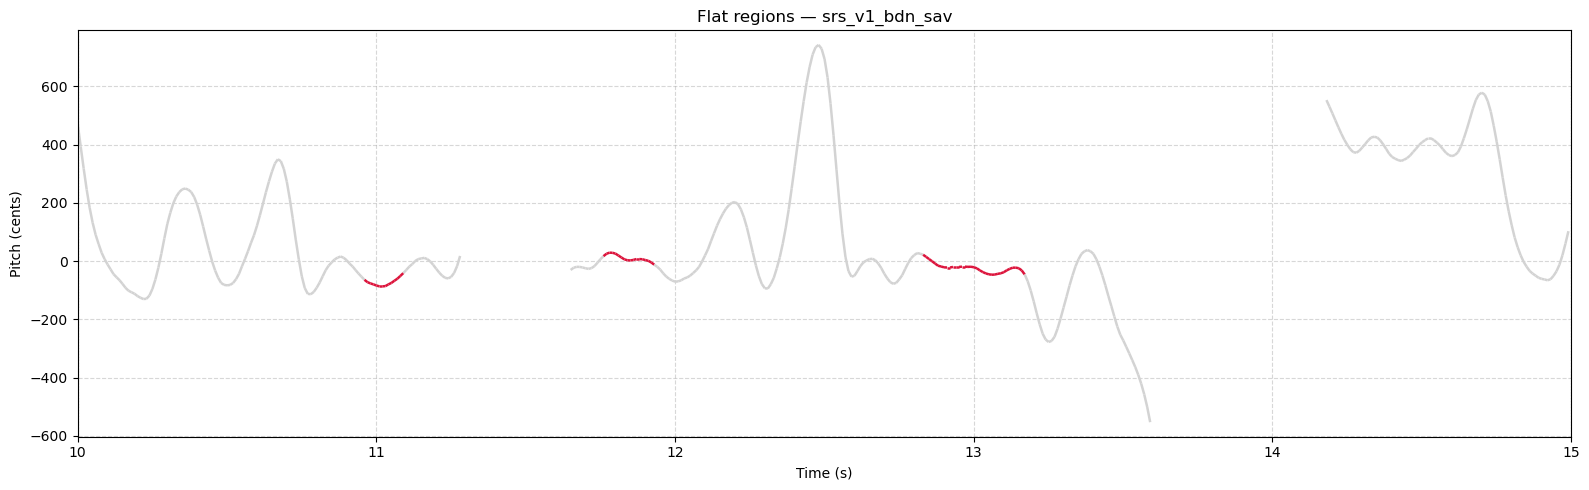

(<Figure size 1600x500 with 1 Axes>,
 <Axes: title={'center': 'Flat regions — srs_v1_bdn_sav'}, xlabel='Time (s)', ylabel='Pitch (cents)'>)

In [8]:
from src.utils.plot import plot_pitch_with_flat_regions

t_min = float(df.select(pl.col(S.TIME_COL).min()).item())
t0 = t_min + 10.0
t1 = t0 + 5.0

plot_pitch_with_flat_regions(
    df,
    time_col=S.TIME_COL,
    pitch_col=pitch_col,
    stable_col=S.STABLE_COL,
    time_range=(t0, t1),
    title=f"Flat regions — {recording_id}",
    pitch_unit="cents" if pitch_col.endswith("_cents") else "hz",
)


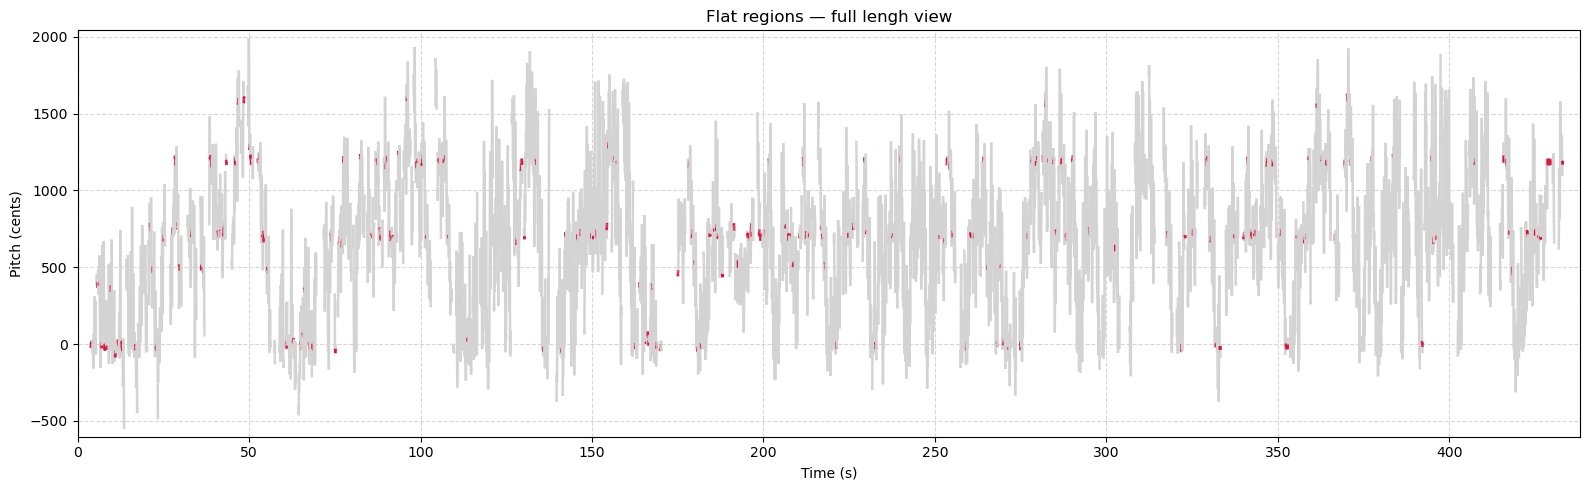

In [9]:
from src.utils.plot import plot_pitch_with_flat_regions

fig, ax = plot_pitch_with_flat_regions(
    df,
    time_col="time_rel_sec",
    pitch_col="f0_savgol_p3_w13_cents",
    stable_col="flat_region",
    pitch_unit="cents",
    title="Flat regions — full lengh view",
)

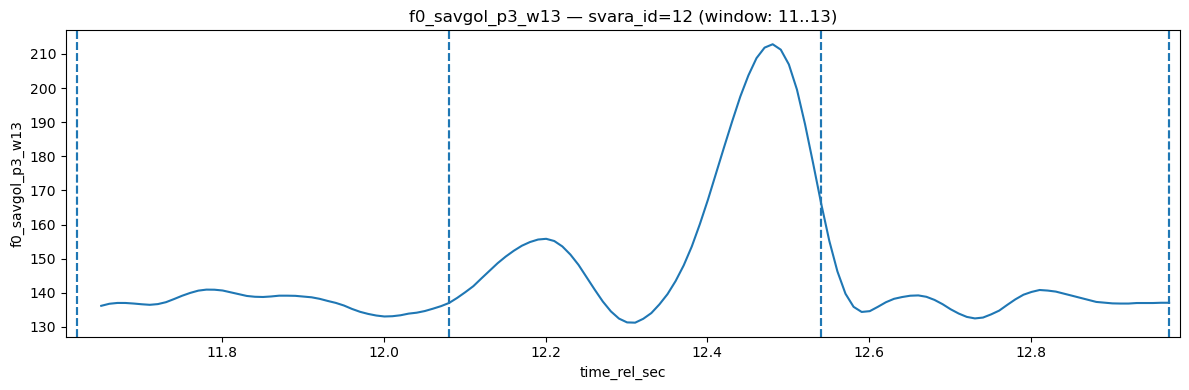

In [10]:
from src.utils.plot import plot_pitchcurve_svara_window
from src.io.pitch_io import load_preprocessed_pitch

df_pitch = load_preprocessed_pitch(recording_id, convert_to_cents=False)

fig, ax = plot_pitchcurve_svara_window(
    df_pitch,
    svara_id=12,
    pitch_col="f0_savgol_p3_w13",
    window_n=2,
)

ColumnNotFoundError: "f0_savgol_p3_w13_cents" not found

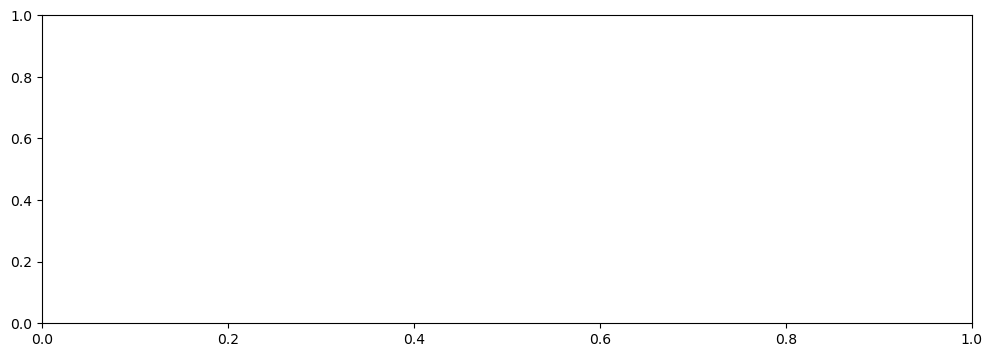

In [ ]:
from src.utils.plot import plot_svara_window_with_flat_regions

fig, ax = plot_svara_window_with_flat_regions(
    df,
    svara_id=12,
    pitch_col="f0_savgol_p3_w13_cents",
    stable_col="flat_region",
    window_n=2,   # 2 veïns
)